# libraries


In [815]:
# Standard IPython notebook imports
%matplotlib inline

import os

import pandas as pd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [816]:
df = pd.read_csv('data/responses.csv')
df = df.fillna(-1.0)
df.shape

(1010, 150)

In [817]:
#categories
CATEGORIES_IDS = [*range(31,36),*range(38,41), *range(42,46), 48]
IT_IDS = [36,37,58]

#to_delete
OUTSIDE_IDS = [47, 49, 50, *range(53,58), 59, 60, 85, 106, 110, 113, 116]
INSIDE_IDS  = [41, 72]
UNREL_IDS   = [*range(0,31), 46, 51, 52, *range(62,72), *range(73,85), *range(86,106), 
               *range(107,110), *range(111,113), *range(113,116), *range(117,150)]

In [818]:
cat_df = (df[df.columns[CATEGORIES_IDS]]).copy()
cat_df["IT"] = (df[df.columns[IT_IDS[0]]] + df[df.columns[IT_IDS[1]]] + df[df.columns[IT_IDS[2]]])/3
oth_df = (5.0 - df[df.columns[INSIDE_IDS ]]).copy()
oth_df = oth_df.rename(columns={'Reading': 'Dislikes reading', 'Fear of public speaking': 'Doesnt fear public speaking'})
oth_df = oth_df.join((df[df.columns[OUTSIDE_IDS]]))

In [819]:
cat_df.shape, oth_df.shape

((1010, 14), (1010, 17))

In [820]:
df_new = cat_df.copy()
df_new = df_new.join(oth_df)

In [725]:
df_new

,History,Psychology,Politics,Mathematics,Physics,Economy Management,Biology,Chemistry,Geography,Foreign languages,Medicine,Law,Religion,IT,Dislikes reading,Doesnt fear public speaking,Art exhibitions,"Countryside, outdoors",Dancing,Passive sport,Active sport,Gardening,Celebrities,Shopping,Theatre,Fun with friends,Friends versus money,Number of friends,New environment,Socializing,Children
0,1.0,5.0,1.0,3.0,3.0,5.0,3.0,3.0,3.0,5.0,3.0,1.0,1.0,4.000000,2.0,3.0,1.0,5.0,3.0,1.0,5.0,5.0,1.0,4.0,2.0,5.0,3.0,3,4.0,3.0,5.0
1,1.0,3.0,4.0,5.0,2.0,5.0,1.0,1.0,4.0,5.0,1.0,2.0,1.0,3.666667,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,2.0,4.0,4.0,3,4.0,4.0,2.0
2,1.0,2.0,1.0,5.0,2.0,4.0,1.0,1.0,2.0,5.0,2.0,3.0,5.0,2.666667,0.0,3.0,5.0,5.0,5.0,5.0,2.0,1.0,1.0,4.0,5.0,5.0,5.0,3,3.0,5.0,4.0
3,4.0,4.0,5.0,4.0,1.0,2.0,3.0,3.0,4.0,4.0,2.0,5.0,4.0,2.333333,0.0,0.0,5.0,1.0,1.0,1.0,1.0,1.0,2.0,4.0,1.0,2.0,2.0,1,1.0,1.0,2.0
4,3.0,2.0,3.0,2.0,2.0,2.0,3.0,3.0,2.0,3.0,3.0,2.0,4.0,2.333333,0.0,2.0,1.0,4.0,1.0,3.0,1.0,4.0,3.0,3.0,2.0,4.0,3.0,3,4.0,3.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1005,4.0,4.0,2.0,1.0,2.0,1.0,2.0,1.0,4.0,5.0,2.0,1.0,1.0,3.333333,0.0,1.0,5.0,2.0,2.0,4.0,4.0,2.0,4.0,5.0,5.0,5.0,4.0,3,4.0,4.0,3.0
1006,4.0,1.0,1.0,5.0,4.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,5.0,5.000000,4.0,0.0,1.0,5.0,5.0,1.0,5.0,5.0,1.0,2.0,1.0,5.0,2.0,3,5.0,3.0,5.0
1007,2.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,3.333333,1.0,0.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,4.0,1,1.0,1.0,3.0
1008,3.0,5.0,3.0,1.0,1.0,3.0,3.0,3.0,5.0,5.0,3.0,1.0,1.0,4.666667,3.0,0.0,5.0,5.0,4.0,2.0,4.0,1.0,3.0,5.0,5.0,5.0,3.0,3,4.0,3.0,3.0


In [821]:
df_nerds = df_new.loc[df_new['IT'] > 3]
df_other = df_new.loc[df_new['IT'] <= 3]

In [822]:
df_nerds

,History,Psychology,Politics,Mathematics,Physics,Economy Management,Biology,Chemistry,Geography,Foreign languages,Medicine,Law,Religion,IT,Dislikes reading,Doesnt fear public speaking,Art exhibitions,"Countryside, outdoors",Dancing,Passive sport,Active sport,Gardening,Celebrities,Shopping,Theatre,Fun with friends,Friends versus money,Number of friends,New environment,Socializing,Children
0,1.0,5.0,1.0,3.0,3.0,5.0,3.0,3.0,3.0,5.0,3.0,1.0,1.0,4.000000,2.0,3.0,1.0,5.0,3.0,1.0,5.0,5.0,1.0,4.0,2.0,5.0,3.0,3,4.0,3.0,5.0
1,1.0,3.0,4.0,5.0,2.0,5.0,1.0,1.0,4.0,5.0,1.0,2.0,1.0,3.666667,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,3.0,2.0,4.0,4.0,3,4.0,4.0,2.0
5,5.0,3.0,4.0,2.0,3.0,1.0,4.0,4.0,3.0,4.0,4.0,3.0,2.0,3.666667,2.0,2.0,2.0,5.0,1.0,5.0,4.0,2.0,1.0,2.0,1.0,3.0,2.0,3,4.0,4.0,3.0
7,5.0,2.0,3.0,1.0,1.0,1.0,2.0,2.0,3.0,4.0,1.0,2.0,2.0,3.666667,3.0,1.0,1.0,2.0,1.0,4.0,5.0,1.0,3.0,3.0,2.0,4.0,4.0,4,4.0,2.0,4.0
10,3.0,3.0,3.0,2.0,1.0,3.0,2.0,1.0,3.0,5.0,2.0,4.0,2.0,4.333333,2.0,3.0,2.0,4.0,1.0,5.0,1.0,3.0,2.0,5.0,2.0,4.0,3.0,3,3.0,3.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1004,3.0,4.0,1.0,2.0,2.0,3.0,3.0,2.0,3.0,4.0,3.0,2.0,1.0,4.000000,3.0,2.0,3.0,3.0,3.0,5.0,2.0,2.0,1.0,2.0,2.0,5.0,5.0,5,5.0,2.0,4.0
1005,4.0,4.0,2.0,1.0,2.0,1.0,2.0,1.0,4.0,5.0,2.0,1.0,1.0,3.333333,0.0,1.0,5.0,2.0,2.0,4.0,4.0,2.0,4.0,5.0,5.0,5.0,4.0,3,4.0,4.0,3.0
1006,4.0,1.0,1.0,5.0,4.0,2.0,2.0,1.0,2.0,2.0,1.0,1.0,5.0,5.000000,4.0,0.0,1.0,5.0,5.0,1.0,5.0,5.0,1.0,2.0,1.0,5.0,2.0,3,5.0,3.0,5.0
1007,2.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,1.0,1.0,3.333333,1.0,0.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,2.0,3.0,4.0,1,1.0,1.0,3.0


In [823]:
df_nerds_val = df_nerds.iloc[:, 14:32]
df_other_val = df_other.iloc[:, 14:32]
df_nerds_val = pd.DataFrame(round(df_nerds_val.sum(axis = 1)/17).value_counts())
df_other_val = pd.DataFrame(round(df_other_val.sum(axis = 1)/17).value_counts()).rename(columns={0 : 1})
pie_df = pd.concat([df_nerds_val, df_other_val], axis=1)

In [824]:
pie_df = pie_df.rename(index={1.0: "Hardly disagree", 2.0: "Disagree", 3.0: "Neutral", 4.0: "Agree", 5.0: "Strongly agree"})
pie_df = pie_df.rename(columns={0: ' ', 1: '  '})

In [825]:
pie_df

,,
Hardly disagree,NaN,1
Disagree,69.0,47
Neutral,453.0,275
Agree,116.0,49


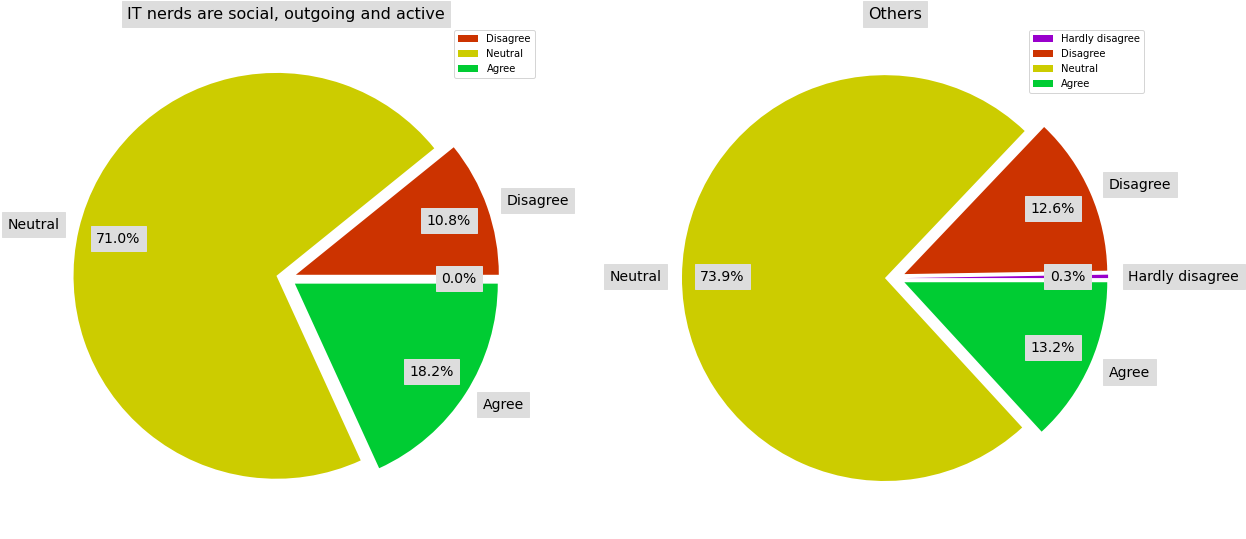

In [826]:
colors = ['#9900cc','#cc3300','#cccc00', '#00cc33','#0099cc']
explode = (0.05,0.05,0.05,0.05)
plot0, plot1 = pie_df.plot.pie(textprops={'backgroundcolor' : '#dddddd', 'fontsize': 14}, subplots=True, colors = colors, figsize=(20, 10), explode = explode, autopct='%1.1f%%', startangle=0, pctdistance=0.80)
plot0.set_title("IT nerds are social, outgoing and active", backgroundcolor = '#dddddd', fontsize = 16)
plot1.set_title("Others", backgroundcolor = '#dddddd', fontsize = 16)
plt.show()

In [827]:
drop_cols=['IT', 'History', 'Psychology', 'Politics', 'Mathematics', 'Physics',
       'Economy Management', 'Biology', 'Chemistry', 'Geography',
       'Foreign languages', 'Medicine', 'Law', 'Religion']

cat_tab =['History', 'Psychology', 'Politics', 'Mathematics', 'Physics',
       'Economy Management', 'Biology', 'Chemistry', 'Geography',
       'Foreign languages', 'Medicine', 'Law', 'Religion']

best_features = SelectKBest(score_func=f_classif, k=17)

In [828]:
df2 = {}
df2['IT'] = df_nerds.copy()-3
for i in cat_tab:
    pom_df = df_other.copy()-3
    df2[i] = pom_df.loc[pom_df[i] > 0]

In [829]:
for i in drop_cols:
    X_tab     = df2[i].drop(drop_cols, axis = 1)        # X = independent columns (potential predictors)
    y_tab     = df2[i][i]                               # y = target column (what we want to predict)
    fit_tab   = best_features.fit(X_tab,y_tab)
    df_scores = pd.DataFrame(fit_tab.scores_)
    feature_scores = pd.concat([pd.DataFrame(X_tab.columns), df_scores],axis=1)
    feature_scores.columns = ['Feature_Name', i]
    print(feature_scores.nlargest(17, i))
    print(" ")

                   Feature_Name        IT
0              Dislikes reading  5.980089
9                      Shopping  5.665048
4                       Dancing  3.933623
14              New environment  3.352080
8                   Celebrities  2.492697
16                     Children  2.279788
12         Friends versus money  2.188655
10                      Theatre  2.168680
1   Doesnt fear public speaking  1.573766
11             Fun with friends  1.076014
6                  Active sport  0.906018
13            Number of friends  0.893260
7                     Gardening  0.863166
15                  Socializing  0.680217
3         Countryside, outdoors  0.624566
5                 Passive sport  0.566522
2               Art exhibitions  0.563380
 
                   Feature_Name   History
7                     Gardening  4.280922
0              Dislikes reading  3.247008
6                  Active sport  2.496799
5                 Passive sport  2.300822
10                      Theatre 